# How accurate is this robot _really_?
#### Analysis of the forward kinematics model of a 6-axis robot arm on a linear track
<img src="robot.png" width="500"/> ![]()

## Table of Contents

[Introduction](#introduction)<br>
[Notes on the Dataset](#dataset_notes)<br>
[Data Processing](#data_processing)<br>
[Analysis: How good is the data?](#analysis)
- [How random are the joint locations?](#random)
- [How are the reference positions distributed throughout space?](#point_distribution)
- [How normally are those spatial distributions?](#normality)

[Analysis: How bad is our error?](#error)<br>
[Searching for signal in the noise: a plethora of plots](#signal)
- [2D and 3D distance vs error](#dist_v_error)
- [Radius vs height with size and hue determined by error](#rad_v_height)
- [X, Y, and Z values vs error](#xyz_v_error)
- [Joint positions vs error](#joint_pos_v_error)

[Can we detect outliers from variation in the distance between our reference points?
](#outliers)<br>
[Conclusion](#conclusion)

<a id="introduction"></a>
## Introduction
For this project I'm working with a dataset of positional measurements for a 6-axis robot arm with end-effector riding on a linear track. 

To create this dataset, I commanded the robot to assume ~300 unique poses, with each pose defined by angular positions of six rotational axes (joints) and the linear position of a track the robot was mounted to. For each pose I have the measured coordinates of three reference points on the end effector which can be used to determine toolpoint location and orientation. These measurements can be compared against predicted values for those positions as calculated through a forward kinematics model for this robot arm.

If you're not familiar with robot arms, here's a quick overview of the kinematics to give you a more intuitive understanding of the joints and how they move. The first important detail is that all of these joints are connected **in series**, much like a human arm starting at the shoulder. The further you move down the kinematic chain, the more the joint's location has been impacted by previous joints. To leverage the arm analogy, A1 and A2 are in the shoulder. A1 swings the arm side-to-side and A2 elevates the arm up and down (where 0 is parallel to the ground and -90 is straight up in the air). The shoulder has no ability to twist, like ours do, and is oriented such that the elbow, A3, can only swing the forearm up and down (the rotational axes of A2 and A3 are parallel). A4 and A5 are in the "wrist" of the robot, where A4 is ability of the wrist to twist (nearly a full 360 degrees!), and A5 is the motion of a forward-and-back flit of the wrist. A6 is where you mount what's referred to as the end effector, which is where all the action on a robot arm takes place. For this robot, we can think of it as having a flat plate on the end capable of infinite rotation. The measurements for this dataset were taken from three reference targets mounted to this plate. Lastly, the the robot is mounted atop a linear track, our E axis, and if we take our analogy one step further...it may as well be like riding a skateboard on a rail that never turns.

I'll start out doing some exploration to get familiar with the data, then perform some analysis to identify descriptive statistics and interesting trends in the error.

Let's start exploring the data!

## Setup

In [233]:
# Import libraries and set defaults
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('precision',4) 

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns

## First Look

In [124]:
# Load dataset into dataframe
robodata = pd.read_csv('robodata2.csv') # has track
robodata.head()

A1     A2     A3     A4    A5     A6    E        xa1        ya1  \
0 -123.6  -85.3  112.0 -152.3   9.2   38.4  500  2259.9428  1211.6205   
1 -149.0 -112.3   72.5 -151.7 -76.8   34.4  500  1905.0266  2646.7188   
2 -149.4  -63.7   10.0 -148.9 -99.2  142.4  500  2381.4893  3063.0044   
3 -149.2  -73.0   63.6 -139.5 -60.9   18.7  500  2821.1862  1891.2526   
4 -139.2  -94.0  102.4 -119.5 -26.9   61.2  500  2264.4436  1874.1573   

         za1        xa2        ya2        za2        xa3        ya3  \
0  2634.2395  2189.7697  1579.7178  2847.1419  2532.2276  1756.9550   
1  1416.2571  1793.7656  2965.3349  1684.2912  2176.3166  3153.4969   
2  2071.0484  2799.0135  3146.6822  2004.4147  2819.0751  2822.5150   
3  2096.6471  2742.5268  2222.8221  2360.4979  3156.2564  2341.5221   
4  2436.3399  2555.8186  2191.7319  2435.7171  2826.8001  1943.1390   

         za3        xn1        yn1        zn1        xn2        yn2  \
0  2654.2718  2259.8146  1211.5632  2634.3399  2189.8734  1579.7642   
1  1619.9981  1905.1049  2646.7539  1416.3544  1793.9702  2965.4795   
2  1720.8424  2381.6203  3063.0265  2071.0614  2799.1635  3146.4710   
3  2335.2456  2821.1732  1891.2494  2096.8945  2742.6162  2222.9057   
4  2210.6189  2264.5178  1873.9825  2436.4488  2555.9305  2191.5221   

         zn2        xn3        yn3        zn3     dx1     dy1     dz1    err1  \
0  2847.1507  2532.3914  1756.7623  2654.1640  0.1282  0.0573 -0.1004  0.1726   
1  1684.3386  2176.5865  3153.4912  1619.9401 -0.0783 -0.0351 -0.0973  0.1297   
2  2004.3748  2819.0344  2822.2261  1720.8945 -0.1310 -0.0221 -0.0130  0.1335   
3  2360.6875  3156.3690  2341.4769  2335.3746  0.0130  0.0032 -0.2474  0.2478   
4  2435.8252  2826.8856  1942.8750  2210.7710 -0.0742  0.1748 -0.1089  0.2189   

      dx2     dy2     dz2    err2     dx3     dy3     dz3    err3  
0 -0.1037 -0.0464 -0.0088  0.1140 -0.1638  0.1927  0.1078  0.2749  
1 -0.2046 -0.1446 -0.0474  0.2550 -0.2699  0.0057  0.0580  0.2761  
2 -0.1500  0.2112  0.0399  0.2621  0.0407  0.2889 -0.0521  0.2964  
3 -0.0894 -0.0836 -0.1896  0.2257 -0.1126  0.0452 -0.1290  0.1771  
4 -0.1119  0.2098 -0.1081  0.2612 -0.0855  0.2640 -0.1521  0.3164

In [125]:
robodata.describe()

A1        A2        A3        A4        A5        A6          E  \
count  291.0000  291.0000  291.0000  291.0000  291.0000  291.0000   291.0000   
mean    -0.4436  -73.9546   79.7131    2.2117   -7.3907  169.9773  3091.0653   
std     97.6388   30.5048   27.9635  102.6337   67.3650  100.3461  1862.8276   
min   -150.0000 -117.0000   10.0000 -175.0000 -100.0000    0.0000   500.0000   
25%    -90.3500  -98.7000   60.8500  -87.5000  -73.6500   97.5000  1500.0000   
50%     -5.0000  -78.3000   83.4000   -1.7000  -24.0000  170.4000  3000.0000   
75%     88.2500  -55.4000  102.8500   98.4500   61.7500  236.3000  5000.0000   
max    150.0000   17.0000  120.0000  175.0000  100.0000  360.0000  6000.0000   

             xa1        ya1        za1        xa2        ya2        za2  \
count   291.0000   291.0000   291.0000   291.0000   291.0000   291.0000   
mean   3250.3669  1844.9870  -231.3574  3247.1368  1785.3077  -237.4210   
std    1274.7867   827.7844  2736.4123  1235.9005   792.3666  2721.4151   
min      41.8485  -603.7319 -4252.7387    -2.3093  -550.7982 -4185.4630   
25%    2345.7085  1367.5626 -2978.1958  2398.9352  1293.2791 -3019.2953   
50%    3203.7316  1900.9187  1242.3346  3250.5509  1894.9616  1277.7112   
75%    4165.0027  2452.3256  2431.0356  4149.0424  2376.1224  2394.4993   
max    7234.5134  3495.2287  3858.3139  6935.6504  3389.6899  3658.9732   

             xa3        ya3        za3        xn1        yn1        zn1  \
count   291.0000   291.0000   291.0000   291.0000   291.0000   291.0000   
mean   3257.6476  1819.9864  -224.9195  3250.3679  1844.9888  -231.3565   
std    1206.5772   750.5107  2730.1215  1274.7606   827.7916  2736.4022   
min     212.5490  -133.0246 -4176.8734    42.0582  -603.6571 -4252.7055   
25%    2375.2783  1263.5037 -2995.5872  2345.7869  1367.6081 -2978.1657   
50%    3251.8904  1914.7879  1276.3487  3203.7698  1900.9466  1242.1826   
75%    4194.6955  2380.8553  2396.8706  4165.1528  2452.2956  2431.0535   
max    6951.6557  3321.4697  3679.0477  7234.2692  3495.3615  3858.3493   

             xn2        yn2        zn2        xn3        yn3        zn3  \
count   291.0000   291.0000   291.0000   291.0000   291.0000   291.0000   
mean   3247.1394  1785.2980  -237.4173  3257.6442  1819.9943  -224.9242   
std    1235.8781   792.3592  2721.4029  1206.5550   750.5093  2730.1151   
min      -2.3090  -550.9075 -4185.3593   212.5795  -133.0973 -4176.8717   
25%    2399.0446  1293.2392 -3019.3637  2375.2965  1263.5333 -2995.6714   
50%    3250.6853  1894.8860  1277.5846  3251.8367  1914.7831  1276.2726   
75%    4149.0775  2376.1447  2394.4489  4194.6645  2380.9186  2396.9214   
max    6935.5264  3389.8393  3658.8514  6951.7270  3321.4241  3679.1291   

            dx1       dy1       dz1      err1       dx2       dy2       dz2  \
count  291.0000  291.0000  291.0000  291.0000  291.0000  291.0000  291.0000   
mean    -0.0010   -0.0018   -0.0009    0.1679   -0.0026    0.0097   -0.0037   
std      0.1171    0.1036    0.0920    0.0681    0.0994    0.1032    0.0840   
min     -0.3335   -0.2506   -0.2474    0.0229   -0.2838   -0.2343   -0.2409   
25%     -0.0782   -0.0739   -0.0670    0.1219   -0.0701   -0.0572   -0.0598   
50%      0.0053   -0.0020   -0.0040    0.1644   -0.0062    0.0160   -0.0077   
75%      0.0709    0.0689    0.0628    0.2105    0.0706    0.0815    0.0591   
max      0.3067    0.3573    0.3239    0.3733    0.2515    0.2823    0.1998   

           err2       dx3       dy3       dz3      err3  
count  291.0000  291.0000  291.0000  291.0000  291.0000  
mean     0.1543    0.0034   -0.0079    0.0046    0.1648  
std      0.0617    0.1160    0.0982    0.0952    0.0708  
min      0.0176   -0.3179   -0.3025   -0.2826    0.0077  
25%      0.1129   -0.0809   -0.0733   -0.0679    0.1165  
50%      0.1463    0.0072   -0.0072    0.0057    0.1572  
75%      0.1971    0.0790    0.0521    0.0787    0.2074  
max      0.3361    0.3025    0.2889    0.2643    0.3494

<a id="dataset_notes"></a>

## Notes on the Dataset

Each row of the dataset represents the robot in a single, unique pose, and there is data for 291 poses. For each pose, we have 
* **columns 1-6, (A1, A2, A3, A4, A5, A6), the joint angles the robot was commanded to** - angles that the robot was commanded to drive each axis to, in degrees. The angles "A1" through "A6" correspond to the angles "A1" through "A6" in the cartoon image above.
* **column 7 (E), the track position the robot was commanded to** - this robot is installed on a linear track, which is parallel to the x-axis. E values in this dataset are spaced in 500 mm increments.
* **columns 8-16, (XA, YA, ZA), the *actual/measured* location of the end effector** - (x, y, z) coordinates (in mm) of each of the three points on the end effector (sufficient to determine not just location but also orientation of robot's toolpoint)
* **columns 17-25, (XN, YN, ZN), the *nominal/predicted* location of the end effector** - expected (x, y, z) coordinates (in mm) of the same three points were calculated  by feeding the joint positions to a forward kinematics model configured for this robot as installed (that's actually the purpose the data was captured for!)
* **columns 26-37, (dx, dy, dz, err), the error in the kinematic model's prediction**  - (dx, dy, dz) are the coordinates (in mm) of the resultant vector if you subtract the nominal/expected position from the actual/measured position (i.e. the 3D error in the model), and "err" is the magnitude of that vector.

## Notes on Methodology

All measurements were made using a high precision laser position tracker, returning the coordinates of these points in a Cartesian coordinate system to a 3-sigma accuracy of +/- 0.025 mm (i.e. 99.7% of measurements are within 0.025 mm of the true value). The data was taken in two batches, one batch for each side of the linear track. In each case the tracker was located at approximately (X=3600 mm, Y = 1500 mm, Z = -4000 mm / +5000 mm).

The coordinate frame is aligned such that:
* X+ points in the direction of A1 = 0.
* Y+ is vertical, aligned to gravity; note that the robot is mounted on an imperfect surface, so this is not perfectly coincident with the vector of the A1 axis.
* Z+ is laterally perpendicular to X, as determined by the right-hand-rule
* The origin is defined as being coincident with the bottom surface of the base beneath the A1 joint, and concentric to A1 rotation.

<a id="data_processing"></a>
## Divide and Conquer
It's unwieldy to look at the data all in one giant table that way. Let's split it up into a handful of dataframes according to the breakdown described above, then start doing some work on it.

In [126]:
# Make dataframe containing just the joint positions for each pose
joints = robodata.iloc[:, : 7]

# Make dataframe containing just the measured positions for each pose
actuals = robodata.iloc[:, 7:16]

# Split dataframe even further into a frame for each reference point
act_pt1 = actuals.iloc[:, 0:3] # measured (x, y, z) values for pt1
act_pt2 = actuals.iloc[:, 3:6] # measured (x, y, z) values for pt2
act_pt3 = actuals.iloc[:, 6:9] # measured (x, y, z) values for pt3

# Make dataframe containing the measured positions in robot coordinates
# (i.e. subtract off the E position so the origin moves with the robot)
def E_translate(position_vector, E_offset):
    return pd.DataFrame({
        'X':position_vector.iloc[:, 0] - E_offset, 
        'Y':position_vector.iloc[:, 1], 
        'Z':position_vector.iloc[:, 2]
    })

rob_pt1 = E_translate(act_pt1, robodata['E'])
rob_pt2 = E_translate(act_pt2, robodata['E'])
rob_pt3 = E_translate(act_pt3, robodata['E'])

# Make dataframe containing just the nominal positions for each pose
nominals = robodata.iloc[:, 16:25]

# Split dataframe even further into a frame for each reference point
nom_pt1 = nominals.iloc[:, 0:3] # nominal (x, y, z) values for pt1
nom_pt2 = nominals.iloc[:, 3:6] # nominal (x, y, z) values for pt2
nom_pt3 = nominals.iloc[:, 6:9] # nominal (x, y, z) values for pt3

# Make dataframe containing just the errors of the positions for each pose
errors = robodata.iloc[:, 25:]

# Split dataframe even further into a frame for each reference point
err_pt1 = errors.iloc[:, 0:4] # error (dx, dy, dz, err) values for pt1
err_pt2 = errors.iloc[:, 4:8] # error (dx, dy, dz, err) values for pt2
err_pt3 = errors.iloc[:, 8:12] # error (dx, dy, dz, err) values for pt3

<a id="analysis"></a>
# Let's start asking questions!
<a id="random"></a>
## The joint positions were supposedly generated randomly, but how random are they?

Each of the poses the robot struck was "randomly generated." I put that in quotes, however, not _just_ because I used a pseudorandom number generator. I actually generated several hundred thousand unique poses in order to get to these 291 realized positions, and had to discard the others because they were not actually compatible with the conditions on the ground. By that I mean I had to discard most of my randomly generated poses as they were either immeasurable or would result in a collision. Let's explore the bias imposed on our data by the fact that the robot was located in a confined work-cell containing physical obstacles

In [127]:
# Print out some high-level descriptive statistics of the joint positions
joint_stats = joints.describe().loc[['mean','std', 'min', 'max']] # grab some informative statistics
joint_stats.loc['range'] = joints.max() - joints.min() # add a row containing the range of travel of each joint
joint_stats

A1        A2        A3        A4        A5        A6          E
mean    -0.4436  -73.9546   79.7131    2.2117   -7.3907  169.9773  3091.0653
std     97.6388   30.5048   27.9635  102.6337   67.3650  100.3461  1862.8276
min   -150.0000 -117.0000   10.0000 -175.0000 -100.0000    0.0000   500.0000
max    150.0000   17.0000  120.0000  175.0000  100.0000  360.0000  6000.0000
range  300.0000  134.0000  110.0000  350.0000  200.0000  360.0000  5500.0000

The above statistics about the joint positions are somewhat informative, particularly the min, max and range attributes, as those tell us about the actual limits of travel for each joint. The next thing I want to know about is the actual distribution of joint positions throughout their allowable range, and though the mean and standard deviation hint at this, they're a bit lacking in information. Let's create a scatter matrix from this data to investigate both the spread of each individual joint's positions as well as see if there's any apparent relationships between our joints. 

In [87]:
# Create pairplot of joint positions
sns.set(style="white", context="notebook")
p = sns.pairplot(joints, plot_kws={'alpha': 0.5})
p.fig.set_size_inches(10,10) # sized to fit on my screen; adjust as needed

Pow! Okay. Once we're over the information overload we can start actually gleaning some information from this high-level view of our joint data. Despite the fact that all of the poses the robot took on were "randomly generated", it's quite clear that they're not uniformly distributed across the joint ranges. Most of these observations can be readily explained by some understanding of how each joint affects the overall position of the robot, as well as the context within which the data was taken. Let's talk through some quick observations about each axis, as well as some of the conditions on the ground that explain them:

* **A1** - very few points around 0 degrees (middle of travel) with most of the points tending to group at high angles. This is likely do to the laser tracker being placed at +/- 90 degrees and the track being inline with A1=0, causing some selection bias for these locations. Looking at the pairplots, it appears that there is some significant interplay between A1 and pretty much all of the other axes.
* **A2 and A3** - these axes present themselves similarly, though opposite. A2 is distinctly right-skewed and tapers off to nearly 0 for high angles. A3 is *left*-skewed and actually flattens out to approximately uniform representation for low angles. Observing their pairplot, we can see that there's actually some significant correlation between A2 and A3.
* **A4** - semi-symmetric bimodal distribution with lower representation near 0/slightly positive. Strong relationships apparent with the A1-5, and and minimal interplay with A6 and E.
* **A5** - another symmetric bimodal distribution, though this one is a bit sharper and than A4's. Distinct relationships are evident with A1, A2, A3, A6, and E.
* **A6** - nearly normal distribution with a peculiar spike near A6=0. Apparent relationship with A2, A3, and A5, weaker with the rest.
* **E** - not much representation at the center of travel, with main groupings of points at the extremes and the highest concentration at the E=500. This is most easily explained by the fact that the tracker was located at the middle of the track and actually acted as an obstacle when the robot was in that area. Additionally, when E was at the low end of travel, the robot could reach most of the range of A1, whereas at the high end of travel there was a wall in the way eliminating many possible positions.

<a id="point_distribution"></a>
## How were the reference positions distributed throughout the space?
To answer this question, let's look at some basic stats about the measured reference positions and then generate three orthogonal views of the work envelope to see our points are spread relatively evenly around the space. Because all three reference points move together on the same piece of structure, we'll just look at data for a single point for much of this.

In [128]:
# Print out some useful stats about the measured reference positions
actuals_stats = actuals.describe().loc[['mean','std', 'min', 'max']]
actuals_stats.loc['range'] = actuals.max() - actuals.min() # add a row containing the range of travel of each joint
actuals_stats

xa1        ya1        za1        xa2        ya2        za2  \
mean   3250.3669  1844.9870  -231.3574  3247.1368  1785.3077  -237.4210   
std    1274.7867   827.7844  2736.4123  1235.9005   792.3666  2721.4151   
min      41.8485  -603.7319 -4252.7387    -2.3093  -550.7982 -4185.4630   
max    7234.5134  3495.2287  3858.3139  6935.6504  3389.6899  3658.9732   
range  7192.6649  4098.9606  8111.0526  6937.9597  3940.4881  7844.4362   

             xa3        ya3        za3  
mean   3257.6476  1819.9864  -224.9195  
std    1206.5772   750.5107  2730.1215  
min     212.5490  -133.0246 -4176.8734  
max    6951.6557  3321.4697  3679.0477  
range  6739.1067  3454.4943  7855.9211

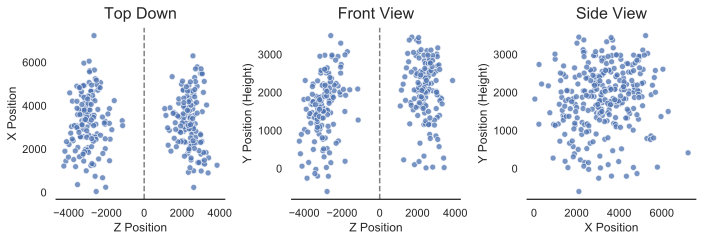

In [118]:
# Import some helpers
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from matplotlib.patheffects import withStroke

# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=False)
sns.despine(left=True)
sns.set(style="white", context="notebook")

# Define various labels and parameters to use below
labels = ['Top Down', 'Front View', 'Side View']
xlabels = ['Z Position', 'Z Position', 'X Position']
ylabels = ['X Position', 'Y Position (Height)', 'Y Position (Height)']
x = ['za1', 'za1', 'xa1']
y = ['xa1', 'ya1', 'ya1']
ground = -500
x_mid = (actuals['xa1'].max() - actuals['xa1'].min()) / 2

# Plot scatter plots showing distribution of reference points in Cartesian space
for i, ax in enumerate(axes):
    sns.scatterplot(x=x[i], y=y[i], data = act_pt1, alpha=0.75, ax=ax)
    ax.set_title(labels[i], fontsize=16, verticalalignment='bottom')
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
    
axes[0].axvline(0, color='grey', linestyle='dashed')
axes[1].axvline(0, color='grey', linestyle='dashed')

plt.tight_layout()

In the plots above, we see the spread of data from three orthogonal views. The points tend to be clustered in a cloud about 2-4 meters from Z0, though relatively well distributed in X and Y. Points basically don't exist near Z0 (over the track). Let's check it out through a different perspective with some histograms.

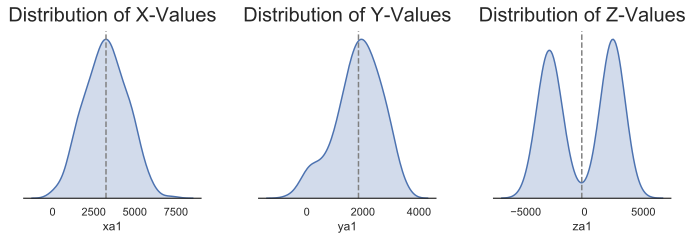

In [119]:
# Create histograms of x, y, and z values 
# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharex=False)
sns.despine(left=True)
labels = ('Distribution of X-Values', 'Distribution of Y-Values', 'Distribution of Z-Values')
pts = ('xa1', 'ya1', 'za1')

# Plot filled kernel density estimates
for i, ax in enumerate(axes):
    sns.distplot(actuals[pts[i]], hist=False, kde_kws={"shade": True}, ax=ax)
    ax.axvline(actuals[pts[i]].mean(), color='grey', linestyle='dashed')
    ax.set_title(labels[i], fontsize=20, verticalalignment='bottom')

plt.setp(axes, yticks=[])
plt.tight_layout()

<a id="normality"></a>
## How normal are those distributions, really?
Not that I expect to use this information in any meaningful way but let's make some normal Q-Q plots of our X, Y, and Z values to compare the spread of our data to a standard normal distribution and see how normal the data really is. For funsies.

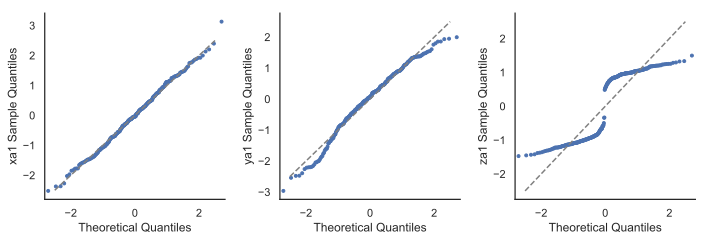

In [122]:
# Create qqplot of reference positions
# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(10, 3.5))
sns.set(style="white", context="notebook")
sns.despine()

# Plot Q-Q plots of each
for i in range(3):
    sm.qqplot(actuals.iloc[:,i], fit=True, ylabel=(str(actuals.columns[i]) + " Sample Quantiles"), 
              marker='.', ax=axes[i])
    axes[i].plot([-2.5,2.5],[-2.5,2.5], color='grey', linestyle='dashed')
plt.tight_layout()
plt.show()

The results? Since a truly normal distribution would yield a y = x relationship:
- X: quite normal!
- Y: Kinda normal?
- Z: Not normal at all!

<a id="error"></a>
## So, how bad is the error in our kinematic model?
Okay, enough with just looking around, let's actually analyze our error. There are a lot of ways to answer that question, and we'll work through some of them...but let me first quickly describe our error values. dx, dy, and dz represent the difference between where we measured a reference point and where our kinematic model predicted it would be based on the given joint positions. The _err_ value reported for each point is simply the magnitude of its three error vectors (hence it's always positive and non-directional). As with before, all reported values are in millimeters.

Let's start just by looking at our basic summary statistics.

In [129]:
error_stats = errors.describe().loc[['mean','std', 'min', 'max']]
error_stats.loc['range'] = errors.max() - errors.min() # add a row containing the range of errors for each column
error_stats

dx1     dy1     dz1    err1     dx2     dy2     dz2    err2     dx3  \
mean  -0.0010 -0.0018 -0.0009  0.1679 -0.0026  0.0097 -0.0037  0.1543  0.0034   
std    0.1171  0.1036  0.0920  0.0681  0.0994  0.1032  0.0840  0.0617  0.1160   
min   -0.3335 -0.2506 -0.2474  0.0229 -0.2838 -0.2343 -0.2409  0.0176 -0.3179   
max    0.3067  0.3573  0.3239  0.3733  0.2515  0.2823  0.1998  0.3361  0.3025   
range  0.6403  0.6078  0.5713  0.3504  0.5353  0.5166  0.4407  0.3185  0.6204   

          dy3     dz3    err3  
mean  -0.0079  0.0046  0.1648  
std    0.0982  0.0952  0.0708  
min   -0.3025 -0.2826  0.0077  
max    0.2889  0.2643  0.3494  
range  0.5914  0.5469  0.3417

### Initial Observations
- By looking at how close our d-values are to 0, we can tell that our error is pretty well centered. Note that this is actually somewhat expected, as the laser tracker's coordinate system was generated by performing a best fit of measured positions to the robot's coordinate system.
- Our maximum 3-dimensional error is 0.3733 mm, on the 1st reference point.
- We see the largest range of errors in dx1, spanning 0.6403 mm

Of course, the goodness of this error is relative to the application. For perspective, many aerospace manufacturing applications require the toolpoint (the position of reference point 1) to be located within 0.5 mm of the target position or better. 

<a id="signal"></a>
## Searching for signal in the noise
We're really getting to the meat of the analysis, now. When I think about assessing the quality of the model, quantifying the accuracy of the predictions is only part of the answer. The question I'm really interested in asking, however, is if we can identify any consistent patterns in the error that provide opportunity for improvement. If we can't find any trends within the error then all we can really do is chalk it up as noise. If, however, we _can_ distinguish some signal in the noise, then we can potentially incorporate that into our kinematic model to improve our accuracy. We'll begin our hunt with a plethora of plots, as described below.

How does distance from the robot's y-axis or origin relate to positional error?
- 2D radius vs error
- 3D radius vs error

Is there correlation between error and location in Cartesian space?
- radius vs height with error indicated by point size and hue 
- measured x, y, and z values vs error
- x vs y  with error indicated by point size and hue
- x vs z  with error indicated by point size and hue
- z vs y  with error indicated by point size and hue

Is there correlation between joint positions and error?
- each joint position vs error

<a id="dist_v_error"></a>
### 2D and 3D Distance vs Error
To plot the distance from the robot Y-axis or origin to the measured points, we'll first have to calculate those values since they don't actually come in the original dataset. Once we've got those values we'll produce a 2x4 grid of regression plots showing the relationship between distance and error. The first column will contain the 2D radii on the X-axis and the second column will have the 3D radii on the X-axis. By rows, we'll show error in X, Y, Z, and then finally the full 3D error on the final row. For each plot I'll go ahead and show the datapoints for all three measured reference points, so we'll be able to see if all three regression lines stack up on top of each other or if there's actually significant variation between the reference points.

In [211]:
# Calculate radial distance (from Y-axis) to each measured location
act_radius1 = np.linalg.norm(rob_pt1.iloc[:,[0,2]], axis=1)
act_radius2 = np.linalg.norm(rob_pt2.iloc[:,[0,2]], axis=1)
act_radius3 = np.linalg.norm(rob_pt3.iloc[:,[0,2]], axis=1)

# Create radius dataframe
act_radii = pd.DataFrame({'pt1 radius':act_radius1, 'pt2 radius':act_radius2, 'pt3 radius':act_radius3})
display(act_radii.describe().loc[['count','mean','std', 'min', 'max']])

# Calculate distance from robot base (origin) to each measured position
act_mag1 = np.linalg.norm(rob_pt1, axis=1)
act_mag2 = np.linalg.norm(rob_pt2, axis=1)
act_mag3 = np.linalg.norm(rob_pt3, axis=1)

# Create radius dataframe
act_mags = pd.DataFrame({'pt1 distance':act_mag1, 'pt2 distance':act_mag2, 'pt3 distance':act_mag3})
display(act_mags.describe().loc[['count','mean','std', 'min', 'max']])

# Make some pointers to the data
distances = (act_radius1, act_radius2, act_radius3, act_mag1, act_mag2, act_mag3)

pt1 radius  pt2 radius  pt3 radius
count    291.0000    291.0000    291.0000
mean    3021.9272   3009.8563   3015.7650
std      572.1694    580.0360    572.9565
min     1622.0607   1646.6963   1377.0124
max     4422.8493   4466.6714   4465.4220

pt1 distance  pt2 distance  pt3 distance
count      291.0000      291.0000      291.0000
mean      3649.8189     3606.4957     3618.4289
std        474.0684      448.7896      450.9342
min       2232.7773     2285.0525     2313.7356
max       4590.5039     4645.4818     4742.6281

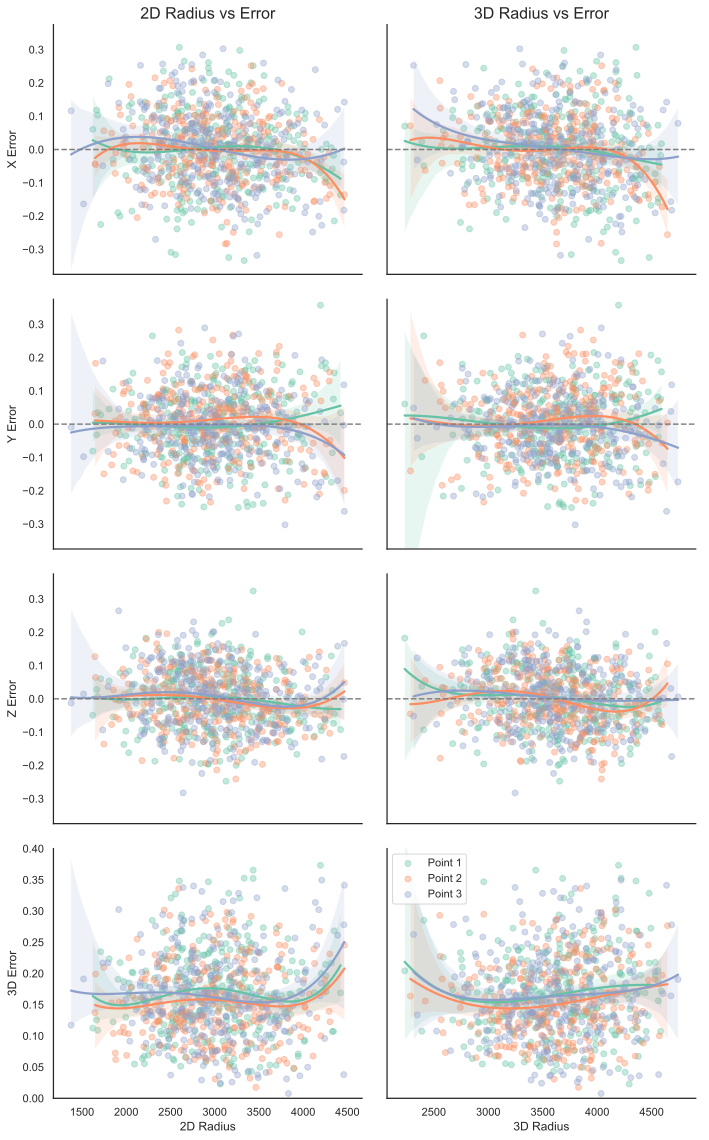

In [210]:
# Scatterplots w/ regression lines of 2D radius and 3D radius vs error
# Set up figure
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 16), sharex='col', sharey='row')
sns.despine()
sns.set(style="white", context="notebook")

# Configure plot parameters
labels = ('Point 1', 'Point 2', 'Point 3')
colors = ('#66c2a5', '#fc8d62', '#8da0cb')
ylabels = ('X Error', '', 'Y Error', '',  'Z Error', '',  '3D Error', '')

# Plot each dataset
for i, ax in enumerate(axes.flatten()):
    for j in range(3):
        sns.regplot(x=distances[j + 3 * (i % 2)], y=errors.iloc[:, 4 * j + i // 2], truncate=True, 
                    label=labels[j], color=colors[j], scatter_kws=dict(alpha=0.375), order=4, ax=ax)
    ax.set_ylabel(ylabels[i])
    if i < 6:
        ax.axhline(y=0, color='grey', linestyle='dashed')
        ax.set_ylim(-0.375, 0.375)
    else:
        ax.set_ylim(0, 0.4)

# Labels
axes[0, 0].set_title('2D Radius vs Error', fontsize=16)
axes[0, 1].set_title('3D Radius vs Error', fontsize=16)
axes[3, 0].set_xlabel('2D Radius')
axes[3, 1].set_xlabel('3D Radius')
axes[3, 1].legend()

# Nicer screen formatting
plt.tight_layout()

Let's get this out of the way: I know, it looks like confetti. But what does all this confetti _mean_? Well, frankly it means the model is actually quite good, in the sense that the more the data looks disorderly and chaotic the more we can say it's already optimized, and even fitting a 4th order polynomial to the data it seems that on average the error is pretty flat regardless of the radius. The main thing that jumps out is that _maybe_ we tend to see an increase in error when very far or very close, but I'm more inclined to believe that's an artifact of not much data on the ends and the natural tendency for higher order polynomials to shoot off to infinity on the ends (note the fat tails on the confidence intervals). 

<a id="rad_v_height"></a>
### Radius vs height with error as color or size
The above plots suggest there's not much correlation between distance and error, but it's a bit tough to really distinguish the difference between the 2D and 3D radii plots. Let's look at that a bit more directly by 2D radius vs height and make our highest errors stand out by sizing and coloring them accordingly.

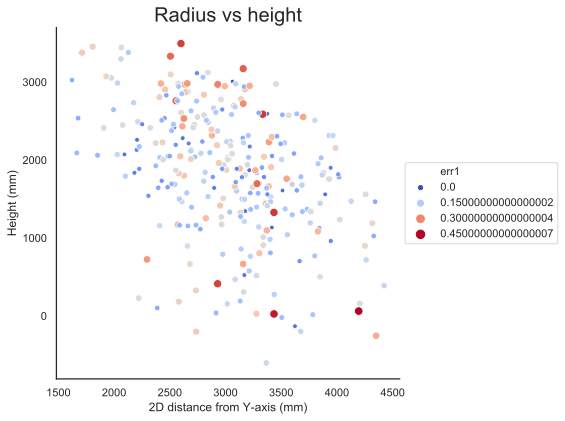

In [16]:
# Set up the matplotlib figure
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
sns.despine()
sns.set(style="white", context="notebook")
sns.scatterplot(x=act_radius1, y=act_pt1['ya1'], hue=errors['err1'], size=errors['err1'], palette='coolwarm', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Axis definitions
ax.set_title("Radius vs height", fontsize=20)
ax.set_xlabel("2D distance from Y-axis (mm)")
ax.set_ylabel("Height (mm)")
  
# Nicer screen formatting
plt.tight_layout()

Much as I want a trend to reveal itself, I'm inclined to say we've been foiled once again! While there is a moderate clustering of high-error points around the top center, it would be a stretch to call it a trend, as they're also scattered around the rest of the plot, as well as surrounded by low-error points.

<a id="xyz_v_error"></a>
### X, Y, and Z values vs error

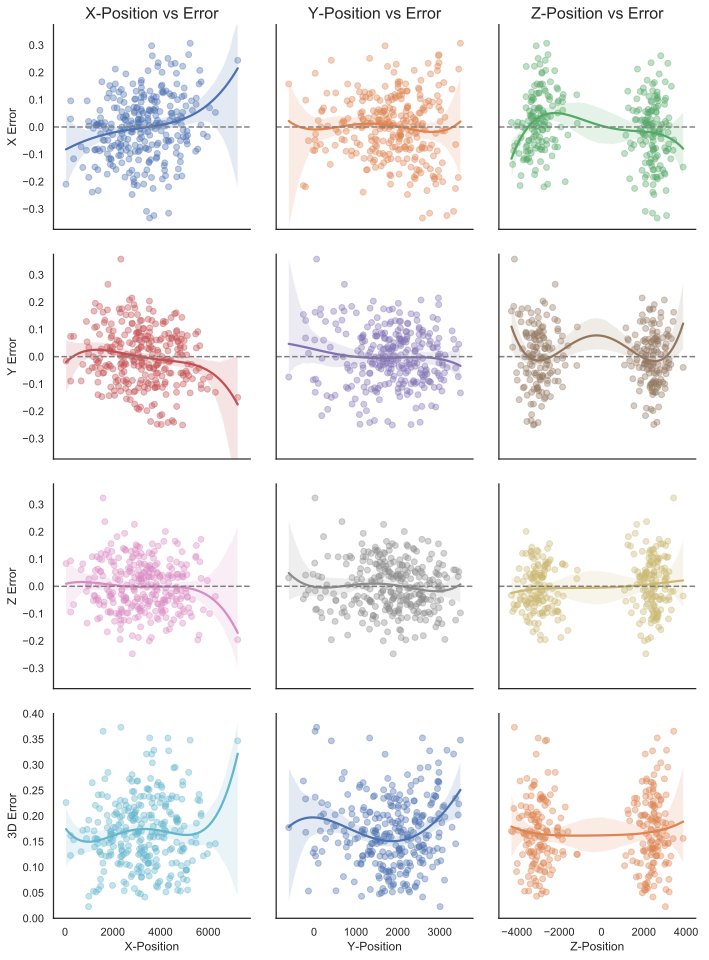

In [229]:
# Set up figure
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 13.5), sharex='col', sharey='row')
sns.despine()
sns.set(style="white", context="notebook")

# Configure plot parameters
#colors = ('#66c2a5', '#fc8d62', '#8da0cb')
titles = ('X-Position vs Error', 'Y-Position vs Error', 'Z-Position vs Error')
xlabels = ('X-Position', 'Y-Position', 'Z-Position')
ylabels = ('X Error', 'Y Error', 'Z Error', '3D Error')

# Plot each dataset
for i, ax in enumerate(axes.flatten()):
    sns.regplot(x=act_pt1.iloc[:, i % 3], y=errors.iloc[:, i // 3], order=4, truncate=True,
                scatter_kws=dict(alpha=0.375), ax=ax)
    if i < 3:
        ax.set_title(titles[i], fontsize=16)
        
    if i < 9:
        ax.set_xlabel('')
        ax.axhline(y=0, color='grey', linestyle='dashed')
        ax.set_ylim(-0.375, 0.375)
    else:
        ax.set_xlabel(xlabels[i % 3])
        ax.set_ylim(0, 0.4)
    
    if i % 3 == 0:
        ax.set_ylabel(ylabels[i // 3])
    else:
        ax.set_ylabel('')
    
# Nicer screen formatting
plt.tight_layout()

Is there much meaningful trend to extract? Don't think so. Is it overfitting on the ends? Sure looks like it. Is this the right way to interpret the Z-position? Certainly not. Am I moving on? Yup.

<a id="joint_pos_v_error"></a>
### Joint position vs error

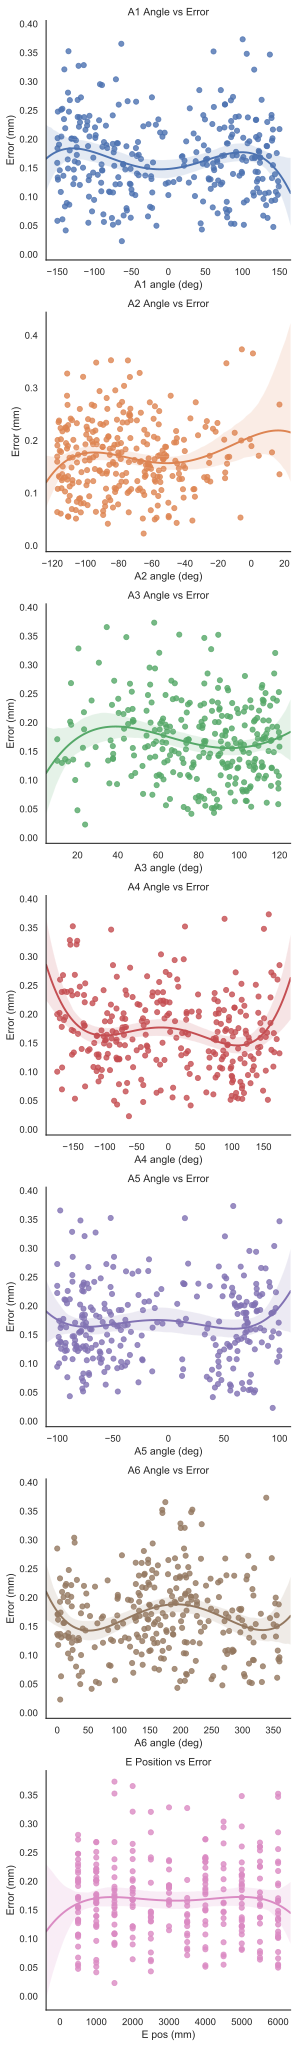

In [230]:
# Set up the matplotlib figure
f, axes = plt.subplots(nrows=7, ncols=1, figsize=(5, 33))
sns.despine()
sns.set(style='white', context='notebook')
titles = ('A1 Angle vs Error', 'A2 Angle vs Error', 'A3 Angle vs Error', 
          'A4 Angle vs Error', 'A5 Angle vs Error', 'A6 Angle vs Error', 'E Position vs Error')
xlabels = ('A1 angle (deg)', 'A2 angle (deg)', 'A3 angle (deg)', 
           'A4 angle (deg)', 'A5 angle (deg)', 'A6 angle (deg)', 'E pos (mm)')

for i, joint in enumerate(joints):
    sns.regplot(x=joints[joint], y=errors['err1'], ax=axes[i], order=4)
    # axis definitions
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].set_xlabel(xlabels[i])
    axes[i].set_ylabel('Error (mm)')
    
# nicer screen formatting
plt.tight_layout()

As with in the previous investigations, I'm inclined to say that there's no apparent trend of error related to axial positions, with the exception of _maybe_ in axis 6. However, even there it seems likely that it's just noise and overfitting.

<a id="outliers"></a>
## Can we detect outliers by looking at variation in the distance between our reference points?
Because the three toolpoints are all mounted to the same rigid fixture, they actually move together through space. This means that, theoretically, the distance between each measurement point should remain constant even as the position and orientation of the robot moves throughout space. Verifying this could be a good way to identify outliers, which in this case could mean erroneous measurements that ought to be discarded from future analysis.

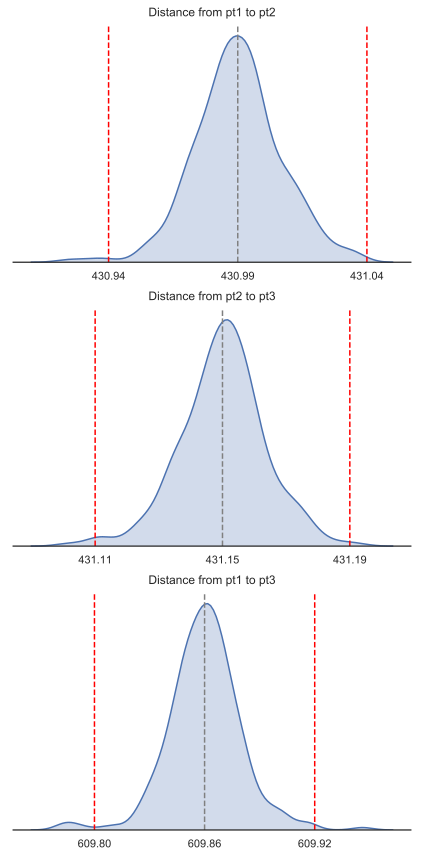

In [234]:
# Calculate difference between (x, y, z) values of each point as vectors pointing from 1 to 2, 2 to 3, and 1 to 3
vec12 = pd.DataFrame(rob_pt1.values-rob_pt2.values, columns=['x12', 'y12', 'z12'])
vec23 = pd.DataFrame(rob_pt2.values-rob_pt3.values, columns=['x23', 'y23', 'z23'])
vec13 = pd.DataFrame(rob_pt1.values-rob_pt3.values, columns=['x13', 'y13', 'z13'])

# Calculate magnitudes of the difference vectors
mag12 = np.linalg.norm(vec12, axis=1)
mag23 = np.linalg.norm(vec23, axis=1)
mag13 = np.linalg.norm(vec13, axis=1)

# Set up the matplotlib figure
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 12), sharex=False)
sns.despine(left=True)
labels = ('Distance from pt1 to pt2', 'Distance from pt2 to pt3', 'Distance from pt1 to pt3')
vec = (mag12, mag23, mag13)

# Plot filled kernel density estimates
for i, ax in enumerate(axes):
    sns.distplot(vec[i], hist=False, kde_kws={"shade": True}, ax=ax)
    mean = vec[i].mean()
    std = vec[i].std()
    left = mean - 3 * std
    right = mean + 3 * std
    ax.axvline(mean, color='grey', linestyle='dashed')
    ax.axvline(left, color='red', linestyle='dashed')
    ax.axvline(right, color='red', linestyle='dashed')
    ax.set_title(labels[i], fontsize=12, verticalalignment='bottom')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    ax.set_xticks([left, mean, right])

plt.setp(axes, yticks=[])
plt.tight_layout()

In [242]:
# Generate a boolean mask to grab outliers out of our dataframes, where outlier is being defined as any pose where the
# distance between any two of the reference points is greater than 3 standard deviations from the mean distance

outlier_mask = ((np.abs((mag12 - np.mean(mag12))) > (3 * np.std(mag12))) | 
                (np.abs((mag23 - np.mean(mag23))) > (3 * np.std(mag23))) | 
                (np.abs((mag13 - np.mean(mag13))) > (3 * np.std(mag13))))

# print out outlier data
display(errors.describe())
display(errors[outlier_mask].describe())

dx1       dy1       dz1      err1       dx2       dy2       dz2  \
count  291.0000  291.0000  291.0000  291.0000  291.0000  291.0000  291.0000   
mean    -0.0010   -0.0018   -0.0009    0.1679   -0.0026    0.0097   -0.0037   
std      0.1171    0.1036    0.0920    0.0681    0.0994    0.1032    0.0840   
min     -0.3335   -0.2506   -0.2474    0.0229   -0.2838   -0.2343   -0.2409   
25%     -0.0782   -0.0739   -0.0670    0.1219   -0.0701   -0.0572   -0.0598   
50%      0.0053   -0.0020   -0.0040    0.1644   -0.0062    0.0160   -0.0077   
75%      0.0709    0.0689    0.0628    0.2105    0.0706    0.0815    0.0591   
max      0.3067    0.3573    0.3239    0.3733    0.2515    0.2823    0.1998   

           err2       dx3       dy3       dz3      err3  
count  291.0000  291.0000  291.0000  291.0000  291.0000  
mean     0.1543    0.0034   -0.0079    0.0046    0.1648  
std      0.0617    0.1160    0.0982    0.0952    0.0708  
min      0.0176   -0.3179   -0.3025   -0.2826    0.0077  
25%      0.1129   -0.0809   -0.0733   -0.0679    0.1165  
50%      0.1463    0.0072   -0.0072    0.0057    0.1572  
75%      0.1971    0.0790    0.0521    0.0787    0.2074  
max      0.3361    0.3025    0.2889    0.2643    0.3494

dx1     dy1     dz1    err1     dx2     dy2     dz2    err2     dx3  \
count  9.0000  9.0000  9.0000  9.0000  9.0000  9.0000  9.0000  9.0000  9.0000   
mean  -0.0652  0.0677  0.0378  0.1857 -0.0269 -0.0176  0.0088  0.1636  0.0516   
std    0.0776  0.0964  0.1399  0.0873  0.0800  0.1360  0.0929  0.0684  0.1296   
min   -0.2146 -0.0878 -0.1620  0.0513 -0.1355 -0.1988 -0.1856  0.0483 -0.1182   
25%   -0.0859 -0.0124 -0.0417  0.1679 -0.0917 -0.1340 -0.0221  0.1292 -0.0263   
50%   -0.0492  0.0613 -0.0074  0.1708 -0.0372 -0.0051  0.0233  0.1436  0.0275   
75%   -0.0293  0.1543  0.0851  0.1718  0.0378  0.0266  0.0485  0.2021  0.1205   
max    0.0347  0.1668  0.3239  0.3655  0.0968  0.2166  0.1218  0.2649  0.2839   

          dy3     dz3    err3  
count  9.0000  9.0000  9.0000  
mean  -0.0504  0.0242  0.1667  
std    0.0771  0.0974  0.0866  
min   -0.1697 -0.1585  0.0311  
25%   -0.0900 -0.0277  0.1296  
50%   -0.0587  0.0157  0.1553  
75%    0.0211  0.1104  0.2479  
max    0.0537  0.1578  0.2897

While we were able to extract 9 potential outliers, I'd say these are uncertain results. In comparing the the errors in these values with the errors of the overall dataset, these outlier points don't have particularly high error values and seem more like a random selection. The standard deviations the measured distance between the reference points is only 0.01-0.02 mm, depending on which you're looking at, which is tiny on the scale of our errors. While this method might work okay for uncovering truly faulty measurements, it doesn't seem to be of much use for this dataset.

<a id="conclusion"></a>
## Conclusion
Phew! That was fun, but I think I've chased that thread about as far as I'm gonna (unless I think of something else fun I want to do...). While for the sake of excitement I was hoping to uncover some glaring flaws in the kinematic model, I'd say that at most all I really laid bare was some of the weaknesses in my methods for capturing the data in the first place. The model looks fantastic. That said, this exploration did give me some insights into how bias creeps into a dataset despite attempts to mitigate that. If you enjoyed this at all, check out my follow-up notebook to this where I explore using different machine learning methods to attempt to predict the x, y, and z values that would emerge based on the just the joint position input.